Theodoros Kassa Aragie

251163893

ECE 9309

Prof. Soodeh Nikan

February 17, 2025

# Implementing Agglomerative Clustering for a Recommender System

Database: https://www.kaggle.com/datasets/nechbamohammed/research-papers-dataset

In [ ]:
# Misc Imports
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from helper import *
# SciKit-Learn Imports
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering 
# from sklearn.preprocessing import StandardScaler 
import scipy.cluster.hierarchy as shc 
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer

## Load Preprocessed Data

In [2]:
# Load cleaned DF
cleanedDF:pd.DataFrame = pd.read_csv(
    "database_clean.csv"
).drop(columns=["id"])

# Load USE embeddings from cleaned dataset
embeddingsDF:pd.DataFrame = pd.read_csv(
    "use_embeddings.csv"
).drop(columns=["id"])

# Train 70%, Val 20%, Test 10%
# Calculate the training portion and the remainder
# 1.0 - 0.7 = 0.3
trnDF, remDF = train_test_split(
    # No need to split into X and Y
    embeddingsDF, test_size=0.3, random_state=42
)
# Use the remainder to calculate the testing and validation portions
# trueTestSize = remainderSize/testSize = 0.1 / 0.3 = 1/3
valDF, tstDF = train_test_split(
    remDF, test_size=float(1/3), random_state=42
)
print(f"Trn: {trnDF.shape}, Tst: {tstDF.shape}, Val: {valDF.shape}")

Trn: (7745, 512), Tst: (1107, 512), Val: (2213, 512)


## Visualize Data and Determine the Best n_clusters for Agglomerative Clustering

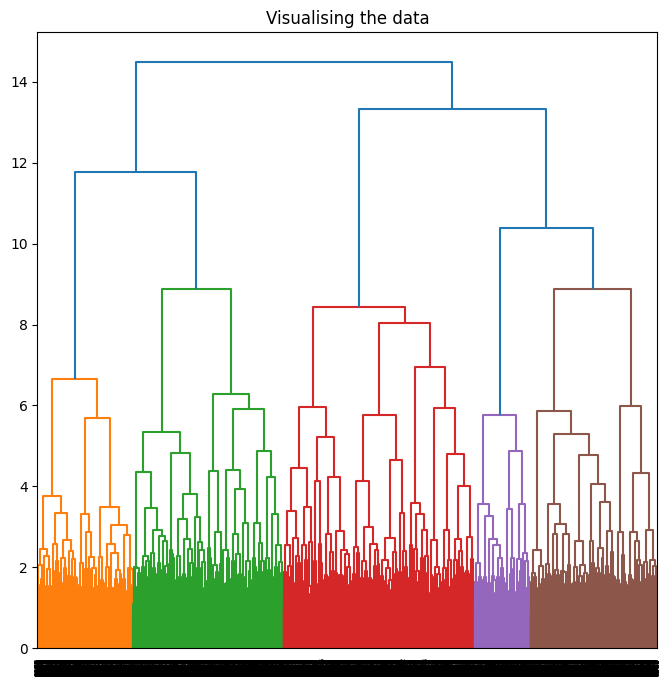

In [3]:
# Dendrogram
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(trnDF, method ='ward')))

[2, 3, 4, 5, 6]


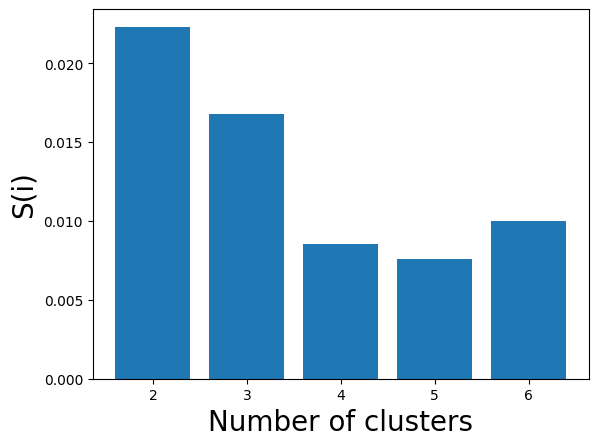

In [4]:
# Use silhouette scores to assess the best AC
# (AgglomerativeClustering) n_clusters value
kVals:list[int] = [i for i in range(2, 7)]
print(kVals)

silhScores:list = [
    silhouette_score(
        trnDF,
        AgglomerativeClustering(n_clusters=i).fit_predict(trnDF)
    ) for i in kVals
]

# Plotting a bar graph to compare the results 
plt.bar(kVals, silhScores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show()

In [5]:
# Calculate labels using optimal AC clusters
bestAC:AgglomerativeClustering = AgglomerativeClustering(n_clusters=2)
trnLabels = bestAC.fit_predict(trnDF)
trnDF["cluster"] = trnLabels
tstLabels = bestAC.fit_predict(tstDF)
tstDF["cluster"] = tstLabels

## Make Recomendations, Cosine Similarity, Save Model

In [6]:
# Function to recommend top n papers (default to top_n=10)
def recommendPapers(testPaperIndex:int, top_n:int=10):
    testPaperClusters:pd.DataFrame = tstDF.iloc[
        testPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == testPaperClusters
    ]
    # Ensure index alignment before selecting embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnDF.index
    )
    # Get appropriate vectors
    testEmbeddings:npt.NDArray = tstDF.iloc[
        testPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnDF.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(testEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnDF.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        testEmbeddings, topEmbeddings
    )
    # Pearson correlation
    corrMean, corrMedian = compute_pearson_correlation(
        testEmbeddings, topEmbeddings.reshape(1, top_n, -1)
    )
    print(corrMean)
    print(corrMedian)
    return similarities, topPapers

# Example usage
testSims, topRecommendations = recommendPapers(0, top_n=10)
print(cleanedDF.iloc[topRecommendations])

[np.float64(0.2594751242953911)]
[np.float64(0.13839824981319904)]
                                               abstract  ...  year
885   Ultra-small touch screen devices tend to suffe...  ...  2016
4141  Different cell buckling between positive and n...  ...  2016
4807  Mass shootings unfold quickly and are rarely f...  ...  2016
4857  Chalmers Publication Library (CPL).#N#    Fors...  ...  2017
5772  In the current research, we tested the utility...  ...  2017
7556  The success of movement detection based on the...  ...  2016
8837  Practicing and playing a sport causes athletes...  ...  2016
8942  The publisher regrets that this article has be...  ...  2017
9057  Die zunehmende Digitalisierung fuhrt zu hohen ...  ...  2017
9392  Chalmers Publication Library (CPL).#N#    Fors...  ...  2017

[10 rows x 7 columns]


In [8]:
# Print out cosine similarity score matrix:
print(testSims)

# Compute average similarity score 
print(cosine_similarity_mean_median(testSims))

# Compute TF-IDF on validation set
(
    tfidfTestsMatrix, testVectors, topRecommendedVectors
) = compute_tfidf_similarity(
    test_texts=cleanedDF.loc[[0], "abstract"].tolist(),
    top10_texts=[cleanedDF.loc[idx, "abstract"] for idx in topRecommendations]
)
print(tfidfTestsMatrix)
print(testVectors)
print(topRecommendedVectors)

# Save the trained model
joblib.dump(bestAC, "./dump/acModel.pkl")

[[0.15340071 0.12714698 0.56914247 0.64382176 0.227075   0.11787565
  0.05808925 0.06578789 0.05861136 0.58685628]]
(array([0.26078074]), array([0.14027384]))
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 691 stored elements and shape (11, 640)>
  Coords	Values
  (0, 323)	0.07808061578704215
  (0, 405)	0.06674046787308198
  (0, 68)	0.07808061578704215
  (0, 249)	0.546564310509295
  (0, 398)	0.23424184736112644
  (0, 343)	0.23424184736112644
  (0, 566)	0.4684836947222529
  (0, 470)	0.07808061578704215
  (0, 513)	0.07808061578704215
  (0, 489)	0.1561612315740843
  (0, 211)	0.23424184736112644
  (0, 125)	0.07808061578704215
  (0, 15)	0.07808061578704215
  (0, 437)	0.05869450488253159
  (0, 141)	0.07808061578704215
  (0, 116)	0.07808061578704215
  (0, 73)	0.07808061578704215
  (0, 210)	0.07808061578704215
  (0, 299)	0.07808061578704215
  (0, 583)	0.07808061578704215
  (0, 104)	0.07808061578704215
  (0, 374)	0.07808061578704215
  (0, 77)	0.07808061578704215
  (0, 556)	0.2342

['./dump/acModel.pkl']

In [9]:
# Reload the model
loadedModel:AgglomerativeClustering = joblib.load("./dump/acModel.pkl")
valLabels = loadedModel.fit_predict(valDF)
valDF["cluster"] = valLabels

In [10]:
# Function to recommend top n papers (default to top_n=10)
def selectPapers(valPaperIndex:int, top_n:int=10):
    valPaperClusters:pd.DataFrame = valDF.iloc[
        valPaperIndex
    ]["cluster"]
    # Get all training papers in the same cluster
    sameClusterPapers:pd.DataFrame = trnDF[
        trnDF["cluster"] == valPaperClusters
    ]
    # Ensure index alignment before selecting embeddings
    sameClusterIndices:pd.Index = sameClusterPapers.index.intersection(
        trnDF.index
    )
    # Get appropriate vectors
    valEmbeddings:npt.NDArray = valDF.iloc[
        valPaperIndex
    ].values.reshape(1, -1)
    trainEmbeddings:npt.NDArray = trnDF.loc[
        sameClusterIndices
    ].values  # Exclude cluster column
    # Compute the distances between points
    distances:npt.NDArray = euclidean_distances(valEmbeddings, trainEmbeddings)[0]
    # Get top-N most similar papers, highest similarity first
    topIndices:npt.NDArray = np.argsort(distances)[-top_n:][::-1]
    topPapers:list[int] = sorted(sameClusterIndices[topIndices].to_list())
    topEmbeddings:npt.NDArray = trnDF.iloc[topIndices].values
    # Compute cosine similarity
    similarities:npt.NDArray = cosine_similarity(
        valEmbeddings, topEmbeddings
    )
    # Pearson correlation
    corrMean, corrMedian = compute_pearson_correlation(
        valEmbeddings, topEmbeddings.reshape(1, top_n, -1)
    )
    print(corrMean)
    print(corrMedian)
    return similarities, topPapers

# Test on new papers
valSims, topSelections = selectPapers(0, top_n=10)
print(cleanedDF.iloc[topSelections])

[np.float64(0.4694829041076491)]
[np.float64(0.5768958349827088)]
                                                abstract  ...  year
1086   Ensuring the continued success of our members ...  ...  2017
1255   Instant messaging applications (apps) are one ...  ...  2016
1654   Older adults are becoming an important market ...  ...  2017
3014   Objective: To study the distribution rules of ...  ...  2016
7147   There is also another publication with the sam...  ...  2016
7537   •   Totally, 32 and 55 modules were obtained f...  ...  2017
7816   This report documents the program and the outc...  ...  2016
9438   How creative thinking tools and computing can ...  ...  2017
10367  Many details from this year's unique ITiCSE st...  ...  2017
10836  Purpose#R##N##R##N##R##N##R##N##R##N#Larry Pru...  ...  2017

[10 rows x 7 columns]


In [11]:
# Print out cosine similarity score matrix
print(valSims)

# Compute average similarity score 
print(cosine_similarity_mean_median(valSims))

# Compute TF-IDF on validation set
(
    tfidfValidMatrix, validVectors, topSelectedVectors
) = compute_tfidf_similarity(
    test_texts=cleanedDF.loc[[0], "abstract"].tolist(),
    top10_texts=[cleanedDF.loc[idx, "abstract"] for idx in topRecommendations]
)
print(tfidfValidMatrix)
print(validVectors)
print(topSelectedVectors)

[[0.62516217 0.19296903 0.59443064 0.14592638 0.62285406 0.42741821
  0.61775463 0.56278611 0.31264179 0.60999974]]
(array([0.47119428]), array([0.57860837]))
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 691 stored elements and shape (11, 640)>
  Coords	Values
  (0, 323)	0.07808061578704215
  (0, 405)	0.06674046787308198
  (0, 68)	0.07808061578704215
  (0, 249)	0.546564310509295
  (0, 398)	0.23424184736112644
  (0, 343)	0.23424184736112644
  (0, 566)	0.4684836947222529
  (0, 470)	0.07808061578704215
  (0, 513)	0.07808061578704215
  (0, 489)	0.1561612315740843
  (0, 211)	0.23424184736112644
  (0, 125)	0.07808061578704215
  (0, 15)	0.07808061578704215
  (0, 437)	0.05869450488253159
  (0, 141)	0.07808061578704215
  (0, 116)	0.07808061578704215
  (0, 73)	0.07808061578704215
  (0, 210)	0.07808061578704215
  (0, 299)	0.07808061578704215
  (0, 583)	0.07808061578704215
  (0, 104)	0.07808061578704215
  (0, 374)	0.07808061578704215
  (0, 77)	0.07808061578704215
  (0, 556)	0.2342

## TF-IDF and Feature Importance Plot

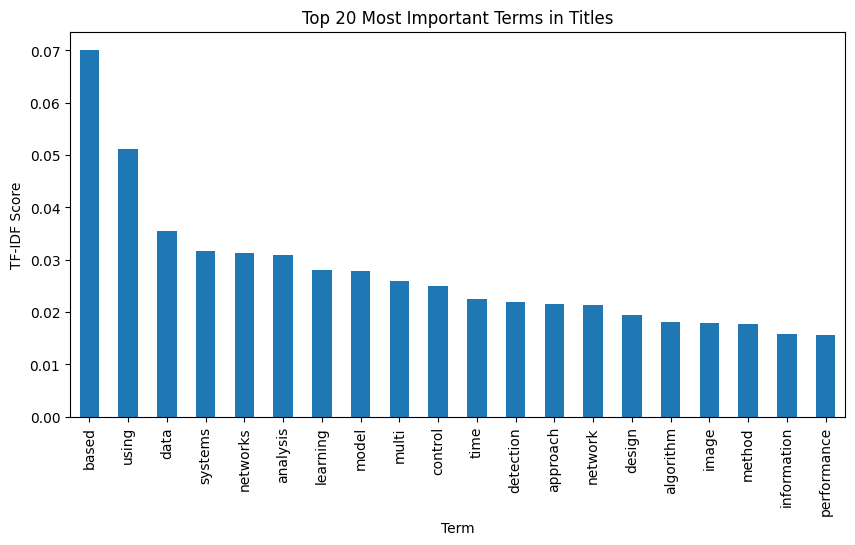

In [12]:
# Convert titles into TF-IDF representation
vectorizer = TfidfVectorizer(stop_words='english', max_features=100)
tfidf_matrix = vectorizer.fit_transform(cleanedDF["title"])

# Convert to DataFrame
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()
)

# Plot top 20 TF-IDF terms
tfidf_df.mean().nlargest(20).plot(kind='bar', figsize=(10, 5))
plt.title("Top 20 Most Important Terms in Titles")
plt.xlabel("Term")
plt.ylabel("TF-IDF Score")
plt.show()